# Application of Fuzzy logic and Genetic Algorithm in Stock Trading

This notebook explores the application of genetic algorithms in optimizing the fuzzy rules as applied in technical analysis of stocks.

In [1]:
# import libraries
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import matplotlib.pyplot as plt
import copy
from Gene import Gene
from Genome import Genome
from Population import Population
from Crossover import single_point, two_point, uniform, linear, SBX, crossover
from Fitness import evaluate_fitness
from Selection import roulette_wheel, RWS, SUS, tournament, rank
import random
from Base_genome import base_genome
from Seed_genome import seed_genome
from helper_module import split_train_test_sets, split_train_set
import Evolution

                Close       Open       High        Low   Volume
Date                                                           
1986-01-02   172.6575   172.6575   172.6575   172.6575    600.0
1986-01-03   172.6575   172.6575   172.6575   172.6575   1900.0
1986-01-06   175.4879   175.4879   175.4879   175.4879   2800.0
1986-01-07   181.1488   175.4879   181.1488   175.4879   3200.0
1986-01-09   181.1488   181.1488   181.1488   181.1488   2600.0
...               ...        ...        ...        ...      ...
2023-09-12  1781.0000  1786.0000  1809.0000  1781.0000  12985.0
2023-09-13  1787.0000  1799.0000  1799.0000  1781.0000  16850.0
2023-09-14  1795.0000  1795.0000  1795.0000  1782.0000  12070.0
2023-09-15  1752.0000  1795.0000  1810.0000  1752.0000  29105.0
2023-09-18  1752.0000  1789.0000  1789.0000  1752.0000  27225.0

[8861 rows x 5 columns]


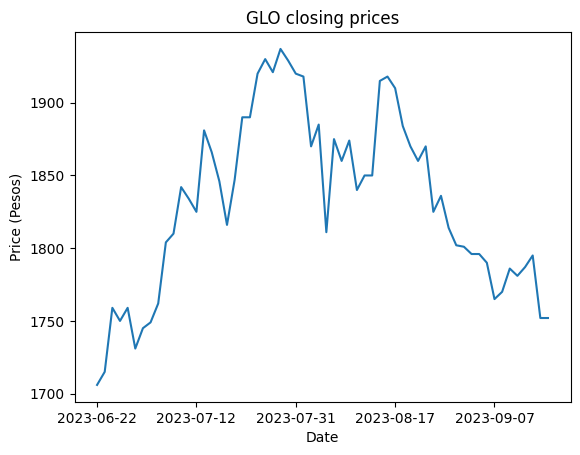

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/GLO.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(series['Close'].tail(60))
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

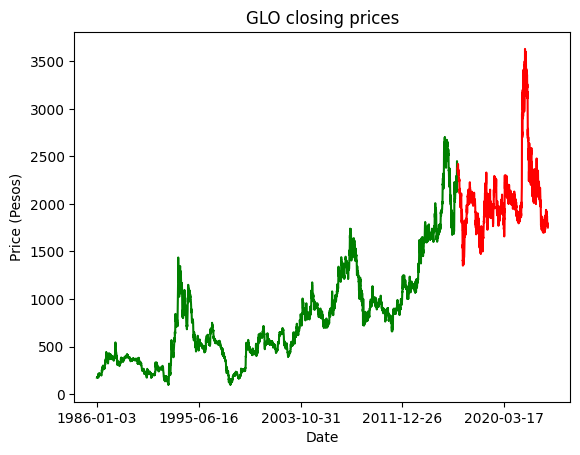

In [3]:
# split data into train and test sets
train, test = split_train_test_sets(series)

# plot the train and test sets
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(train['Close'], 'g')
ax.plot(test['Close'], 'r')
ax.set_xticks(ax.get_xticks()[::2000])
plt.show()

In [4]:
# def split_train_set(series:pd.DataFrame, window:int = 500) -> list[pd.DataFrame]:
#     """
#     This function splits or slices the train set into batches with a corresponding window length

#     Arguments:
#         series:pd.DataFrame
#             a pandas dataframe containing the training set of the 

#     Returns:
#         train_set:list[pd.DataFrame]
#             a list containing multiple pandas dataframes
#     """
#     train_set = list()
#     for i in range(len(series)-window):
#         train_set.append(copy.deepcopy(series[i:i+window]))
#     return train_set

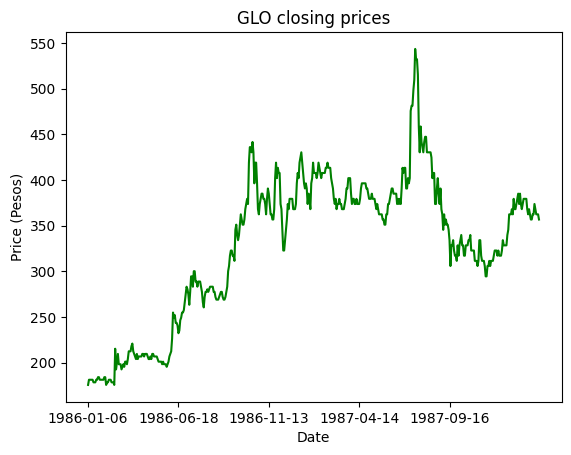

In [5]:
# split the train set into multiple batches
train_set = split_train_set(train)

# plot a sample of the train set
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(train_set[1]['Close'], 'g')
ax.set_xticks(ax.get_xticks()[::100])
plt.show()

In [6]:
# create the base and seed genomes
BASE_GENOME = base_genome()
SEED_GENOME = seed_genome()

In [7]:
# # genome1 = Genome(SEED_GENOME)
# genome1 = Genome(BASE_GENOME)
# genome1.initialize_genome()
# # stock, num_trades, bnh_returns, strat_returns, strat_sharpe_ratio, strat_sortino_ratio, max_drawdown= evaluate_fitness(train_set[2500], genome1)
# fitness = evaluate_fitness(train_set[2500], genome1)
# # print(returns)
# # print(num_trades)
# # print(bnh_returns)
# # print(strat_returns)
# # print(strat_sharpe_ratio)
# print(fitness)
# # print(max_drawdown)

-inf


In [8]:
# genome1 = Genome(SEED_GENOME)
# genome2 = Genome(BASE_GENOME)
# population1 = Population()
# population1.seed_population(seed_genome = genome1, num_seeds = 1)
# population1.add_and_initialize_to_population(num_genomes = 2, base_genome = genome2)
# print(population1)
    

Population 0 has 3 genome/s
It has the following gene/s:
GENE_ID: 4
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 6
Gene name: RSI_window
Value: 144

Gene name: RSI_p1
Value: -0.10275040898280485

Gene name: RSI_p2
Value: 0.4816532266629463

Gene name: RSI_p3
Value: 0.9918287639523691

Gene name: RSI_p4
Value: 0.059685659320397155

Gene name: RSI_low_membership
Value: [49, 97]

Gene name: RSI_middle_membership
Value: [7, 87, 93]

Gene name: RSI_high_membership
Value: [19, 48]

Gene name: entry_condition
Value: [32, 36]

Gene name: stop_loss
Value: 0.8035847719577738

Gene name: z_rolling_window
Value: 9

GENE_ID: 8
Gen

In [9]:
# genome1 = Genome(SEED_GENOME)
# genome2 = Genome(BASE_GENOME)
# genome2.initialize_genome()

# offspring1, offspring2 = SBX(genome1, genome2)
# print(offspring1)
# # print(offspring2)


GENE_ID: 12
Gene name: RSI_window
Value: 38

Gene name: RSI_p1
Value: 0.9767104780581419

Gene name: RSI_p2
Value: 0.6203149312424756

Gene name: RSI_p3
Value: 0.9962402652745422

Gene name: RSI_p4
Value: 0.39886309215731663

Gene name: RSI_low_membership
Value: [6.018737076937904, 32.14725027886376]

Gene name: RSI_middle_membership
Value: [33.48291753578335, 56.51366882211936, 78.78701675704613]

Gene name: RSI_high_membership
Value: [70.60485416401981, 91.54779646926887]

Gene name: entry_condition
Value: [48.24363474472274, 49.08669006725582]

Gene name: stop_loss
Value: 0.9674341312851173

Gene name: z_rolling_window
Value: 28




In [11]:
# # evaluate_fitness_partial = partial(evaluate_fitness, series = train_set[2500])
# genome1 = Genome(SEED_GENOME)
# genome2 = Genome(BASE_GENOME)
# population1 = Population()
# population1.seed_population(seed_genome = genome1, num_seeds = 25)
# population1.add_and_initialize_to_population(base_genome = genome2, num_genomes = 75)
# # new_population = roulette_wheel(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# new_population = RWS(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# # new_population = SUS(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# # new_population = tournament(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# # new_population = rank(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# new_population = crossover(population=new_population)
# # roulette_wheel(population = population1, fitness_func = evaluate_fitness_partial, series = train_set[2500])
# # print(new_population)

In [12]:
# print(type(new_population))

In [13]:
# new_population = crossover(population=new_population)
# print(new_population)

In [14]:
# if not os.path.exists('./checkpoints'):
#     os.makedirs('./checkpoints')
# with open('./checkpoints/checkpoints.pkl', 'wb') as output:
#     pickle.dump(new_population, output, pickle.HIGHEST_PROTOCOL)

# with open('./checkpoints/checkpoints.pkl', 'rb') as input:
#     test_population = pickle.load(input)
    
# print(test_population)

In [15]:
if __name__ == "__main__":
    population = Evolution.run(seed_genome = genome1,
                            base_genome = genome2, 
                            train_set = train_set,
                            fitness_func = evaluate_fitness,
                            num_generations = 200)

12.543669362811684
16.774564431229418
32.083242226833086
50.09857092419596
51.12563295017777
46.076663103392065
39.13060927901763
296.23181806766513
37.878393963536034
32.33582264996686
141.80331304636994
94.34114689702962
29.33041266416694
44.89179793290068
107.26820510062637
35.1820938128747
85.0974982324929
50.85823966368196
35.62272106614239
2366.558344555665
7.365905056296698
230.82516474459084
46.15932127317841
40.43460476987328
10.730657347794933
6.887733732687347
13.451126701565277
108.43573064238903
40.584635239514036
41.44297974871731
95.18618989469277
45.884155199896306
15.818482806547001
21.292495336072932
66.3195908444405
33.03193016564681
60.34729053505698
20.249099008262768
40.84657062046414
583.4482447403834
35.10549065861198
34.645336521131135
30.53335628210481
9.208225682272845
52.25954633726887
15.112506114963313
289.30638220943393
47.45664549850773
54.41012432408177
43.360807958151376
8.534147322001427
23.47605777028116
766.1886243452623
23.151985616340944
31.800526

In [16]:
print(population)

Population 402 has 100 genome/s
It has the following gene/s:
GENE_ID: 10110
Gene name: RSI_window
Value: 2

Gene name: RSI_p1
Value: 0.9691234451902411

Gene name: RSI_p2
Value: 0.8779473852710724

Gene name: RSI_p3
Value: -0.7730327086090858

Gene name: RSI_p4
Value: 0.5060752985585264

Gene name: RSI_low_membership
Value: [72.43710048809059, 96.66245931032563]

Gene name: RSI_middle_membership
Value: [8.90881080144577, 80.74845771105907, 86.03083806899078]

Gene name: RSI_high_membership
Value: [93.96720492720453, 97.5555059725957]

Gene name: entry_condition
Value: [53.87101487132523, 53.97973847171038]

Gene name: stop_loss
Value: 0.6006775245852354

Gene name: z_rolling_window
Value: 2

GENE_ID: 10089
Gene name: RSI_window
Value: 3

Gene name: RSI_p1
Value: 0.9605171201139984

Gene name: RSI_p2
Value: -0.6874814454976867

Gene name: RSI_p3
Value: -0.7409150648586329

Gene name: RSI_p4
Value: 0.5671651750623455

Gene name: RSI_low_membership
Value: [72.43710048809059, 96.6624593103

In [17]:
def sortino_ratio(portfolio_returns:float ,std_downside_portfolio_returns:float, risk_free_rate_returns:float = 2.5) -> float:
    """
    This function computes for the sortino ratio of a given strategy

    Arguments:
        portoflio_returns:float
            the portfolio returns of a strategy
        
        std_downside_portfolio_returns:float
            the standard deviation of the downside of the portfolio retunrs of a strategy

        risk_free_rate_returns:flaot
            the percent return of a risk free strategy (e.g. bonds, bank interests, time deposits, etc.)
    
    Returns:
        sortino_ratio:float
            the sortino ratio of the strategy
    """

    sortino_ratio = (portfolio_returns-risk_free_rate_returns)/std_downside_portfolio_returns
    return sortino_ratio



def sharpe_ratio(portfolio_returns:float ,std_portfolio_returns :float, risk_free_rate_returns:float = 2.5) -> float:
    """
    This function computes the sharpe ratio of a given strategy

    Arguments:
        portfolio_returns:float
            the portfolio returns of a strategy
        
        std_portfolio_returns:float
            the standard deviation of the portfolio returns

        risk_free_rate_returns:float
            the percent return of a risk free strategy (e.g. bonds, bank interests, time deposits, etc.) 
    
    Returns:
        sharpe_ratio:float
            the sharpe ratio of a given strategy
    """
    
    sharpe_ratio = (portfolio_returns-risk_free_rate_returns)/std_portfolio_returns
    return sharpe_ratio


In [18]:
from typing import Union
import numpy as np
import pandas as pd
from Genome import Genome
from fuzzy_ta import fuzzy_TA
import matplotlib.pyplot as plt

def test_fitness(series:pd.DataFrame, genome:Genome) -> list[Union[int, float]]:
    """
    This function evaluates the fitness of the genome
    
    Arguments:
        self:
            some text
            
    Returns:
        None:        
    """     

    # initialize the fuzzy_TA instance
    stock = fuzzy_TA(series)

    # momentum indicators
    stock.RSI(
        window = genome.genome_dict["RSI_window"].value,
        p1 = genome.genome_dict["RSI_p1"].value,
        p2 = genome.genome_dict["RSI_p2"].value,
        p3 = genome.genome_dict["RSI_p3"].value,
        p4 = genome.genome_dict["RSI_p4"].value,
        lo_left_node = genome.genome_dict["RSI_low_membership"].value[0],
        lo_right_node = genome.genome_dict["RSI_low_membership"].value[1],
        md_left_node = genome.genome_dict["RSI_middle_membership"].value[0],
        md_middle_node = genome.genome_dict["RSI_middle_membership"].value[1],
        md_right_node = genome.genome_dict["RSI_middle_membership"].value[2],
        hi_left_node = genome.genome_dict["RSI_high_membership"].value[0],
        hi_right_node = genome.genome_dict["RSI_high_membership"].value[1]
    )
    
    # compute for the total value of z
    stock.z_total()
    stock.df['z_sum_rolling']=stock.df['z_sum'].rolling(genome.genome_dict["z_rolling_window"].value).mean()
    # stock.df['z_sum_ewm'] = stock.df['z_sum'].ewm(span=7).mean()
    # print(stock.df[['z_sum', 'z_sum_rolling', 'z_sum_ewm']].tail(20))

    # plot the z values
    fig, axs = plt.subplots(4, 1, layout='constrained')
    axs[0].plot(stock.df['Close'].tail(450))
    axs[1].plot(stock.df['z_sum'].tail(450))
    axs[2].plot(stock.df['z_sum_rolling'].tail(450))
    # axs[3].plot(stock.df['z_sum_ewm'].tail(200))
    plt.show()

    # initialize the following variables
    stock.df['trailingstop'] = 0.
    stock.df['returns'] = 1.0
    stock.df['change'] = stock.df['Close'].pct_change()+1
    stock.df['regime'] = 0
    has_long_position = False
    num_trades = 0
    buy_locator = list()
    sell_locator = list()
    trailingstop = 1
    
    for i in range(0, len(stock.df)-1):
        # check condition for entry
        condition1 = stock.df['z_sum_rolling'].iat[i] >= genome.genome_dict["entry_condition"].value[1]
        condition2 = has_long_position is False
        condition3 = stock.df['regime'].iat[i] != -1
        if condition1 and condition2 and condition3:
            # buy stock in the next day
            stock.df['regime'].iat[i+1] = 1
            has_long_position = True
            num_trades += 1
            buy_locator.append(stock.df.iloc[i])
            trailingstop = 1
            continue
            
        # establish trailing stop
        if has_long_position is True:
            trailingstop *= stock.df['change'].iat[i]
                
        # check conditions for exit
        condition1 = stock.df['z_sum_rolling'].iat[i] < genome.genome_dict["entry_condition"].value[0]
        condition2 = trailingstop < genome.genome_dict["stop_loss"].value
        condition3 = has_long_position is True
        if( (condition1) or (condition2) ) and condition3:
            stock.df['regime'].iat[i+1] = -1
            has_long_position = False
            sell_locator.append(stock.df.iloc[i])
            trailingstop = 1

    # put 1 between 1 and -1 
    for i in range(1, len(stock.df)):
        if stock.df['regime'].iat[i-1] == 1 and stock.df['regime'].iat[i] == 0:
            stock.df['regime'].iat[i] = 1

    # compute returns
    for i in range(0, len(stock.df)):
        if stock.df['regime'].iat[i] != 0:
            stock.df['returns'].iat[i] = stock.df['change'].iat[i]
    
    # get returns for buy and hold strategy
    bnh_returns = stock.df['change'].cumprod().iat[-1]
    
    # get the returns of the strategy
    strat_returns = stock.df['returns'].cumprod().iat[-1]
    
    # get the downside returns
    downside_returns_df = None
    downside_returns_df = stock.df.loc[stock.df['returns'] < 1]
    
    # compute for the downside returns standard deviation
    downside_returns_std = downside_returns_df['returns'].std()

    # compute for the sortino ration of the strategy
    strat_sortino_ratio = sortino_ratio(portfolio_returns = stock.df['returns'].cumprod().iat[-1], std_downside_portfolio_returns = downside_returns_std)
    
    # compute for max drawdown
    max_drawdown = np.ptp(stock.df["returns"])/stock.df["returns"].max()

    # check if sortino ratio is negative or NaN;
    # if it is negative or NaN, degenerate it into 0
    if np.isnan(strat_sortino_ratio):
        strat_sortino_ratio = float('-inf')

    if strat_sortino_ratio < 0:
        fitness = strat_sortino_ratio * (1/(1+num_trades)) * (1-max_drawdown)
    
    else:
        fitness = strat_sortino_ratio * num_trades * max_drawdown

    
    # compute for the standard deviation of the strategy
    # return_std = stock.df['returns'].std()
    
    # compute for the sharpe ration of the strategy
    # strat_sharpe_ratio = sharpe_ratio(portfolio_returns = stock.df['returns'].cumprod()[-1], std_portfolio_returns = return_std)
    
    # compute for the total returns and plot these
    stock.df['change'].cumprod().plot(label = 'Buy and hold')
    stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()
    # stock.df['returns'].cumprod().tail(450).plot(label = 'Fuzzy Logic')
    
    # show the percent change of the returns for buy and hold vs fuzzy logic
    # print(stock.df['change'].cumprod()[-1], stock.df['returns'].cumprod()[-1])
    
    return strat_sortino_ratio
    # return (stock, num_trades, bnh_returns, strat_returns, strat_sharpe_ratio, strat_sortino_ratio, max_drawdown)

In [ ]:
print()

In [51]:
series_JFC = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/JFC.csv', header = 0, index_col = 'Date')
series_CEB = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/CEB.csv', header = 0, index_col = 'Date')
series_GTCAP = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/GTCAP.csv', header = 0, index_col = 'Date')
series_AEV = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/AEV.csv', header = 0, index_col = 'Date')
series_BPI = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/BPI.csv', header = 0, index_col = 'Date')

GENE_ID: 10089
Gene name: RSI_window
Value: 3

Gene name: RSI_p1
Value: 0.9605171201139984

Gene name: RSI_p2
Value: -0.6874814454976867

Gene name: RSI_p3
Value: -0.7409150648586329

Gene name: RSI_p4
Value: 0.5671651750623455

Gene name: RSI_low_membership
Value: [72.43710048809059, 96.66245931032563]

Gene name: RSI_middle_membership
Value: [43.15672446280897, 72.499625938179, 85.75956068588508]

Gene name: RSI_high_membership
Value: [94.03927170961737, 97.54457052522977]

Gene name: entry_condition
Value: [53.697713602943686, 53.83981760881979]

Gene name: stop_loss
Value: 0.6076278601355749

Gene name: z_rolling_window
Value: 2




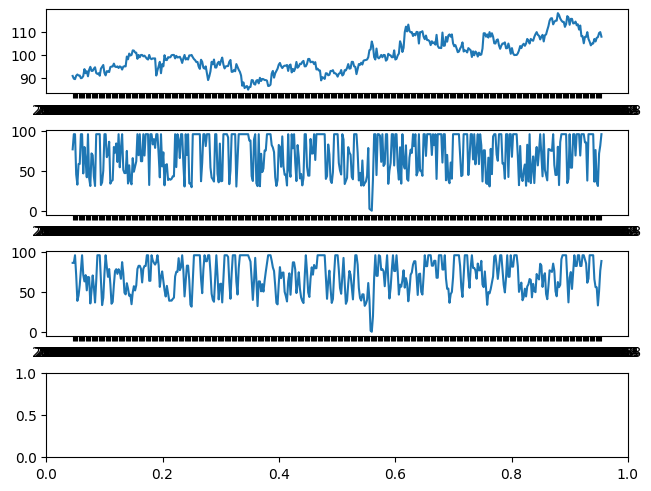

1814.8977684452968

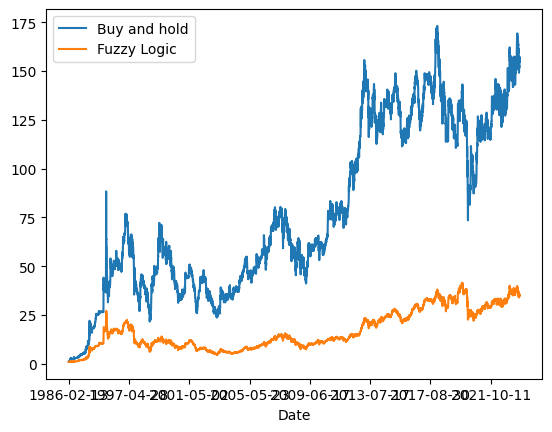

In [52]:
print(population.population[1])
test_fitness(genome = population.population[1], series = series_BPI)
# test_fitness(genome = Genome(SEED_GENOME), series = test)

In [21]:
def main() -> None:
    """
    This function runs all the other functions as provided in the above
    """
    pass
    # use multiprocessing here

In [22]:
# TODO: improve this notebook by using NSGA III in future implementations.
# TODO: visualize the fitness of the generation through PCA
# TODO: refactor SBX crossover